<a href="https://colab.research.google.com/github/AkashKhamkar/Mouse-review-Sentiment-Classifier-using-BERT-/blob/main/Mouse_Sentiment_analysis_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing Transformers package 


In [1]:
!pip install -qq transformers

     |████████████████████████████████| 3.5 MB 13.6 MB/s 
     |████████████████████████████████| 596 kB 68.2 MB/s 
     |████████████████████████████████| 67 kB 6.6 MB/s 
     |████████████████████████████████| 6.8 MB 53.1 MB/s 
     |████████████████████████████████| 895 kB 62.4 MB/s 


We wil be using watermark - an IPython extension for printing date and time stamps, version numbers and hardware information.


In [ ]:
!pip install -q -U watermark

In [3]:
%reload_ext watermark 

In [4]:
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

numpy       : 1.21.5
pandas      : 1.3.5
torch       : 1.10.0+cu111
transformers: 4.16.2



Below are all the imports that are required.

In [5]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import warnings
from warnings import simplefilter

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 8, 6

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Loading the dataset into a pandas dataframe

In [6]:
df = pd.read_csv("/content/drive/MyDrive/amazon_review.csv")
df.head()

,Unnamed: 0,title,body,rating,product
0,0,Super comfortable and long lasting mouse,Bought this mouse after a long research so wri...,5.0,Dell MS116 1000DPI USB Wired Optical Mouse
1,1,Contry of origin is china,I specifically ordered this item because it sa...,1.0,Dell MS116 1000DPI USB Wired Optical Mouse
2,2,Simple and good,"Moved back to a wire mouse, as my wireless opt...",5.0,Dell MS116 1000DPI USB Wired Optical Mouse
3,3,Amazon hiding country of origin of items from ...,This is Chinese product. Amazon conceals count...,1.0,Dell MS116 1000DPI USB Wired Optical Mouse
4,4,Genuine Dell mouse,Its an excellent mouse in this price range. Or...,4.0,Dell MS116 1000DPI USB Wired Optical Mouse


It has an extra column -" Unamed " Lets drop that

In [7]:
df = df.drop(columns=['Unnamed: 0'])

Checking for any NAN values .

In [9]:
df.isnull().any()

title      False
body        True
rating     False
product    False
dtype: bool

Lets check how many total NAN values are there in column " body " 

In [10]:
df['body'].isnull().sum()

29

The column body has 29 NAN values in it so lets drop the corresponding row

In [11]:
df.dropna(subset = ["body"], inplace=True)

checking again for making sure no more NAN values in the dataset

In [12]:
df.isnull().any()

title      False
body       False
rating     False
product    False
dtype: bool

Lets plot and see how the distribution is over rating 1-5 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


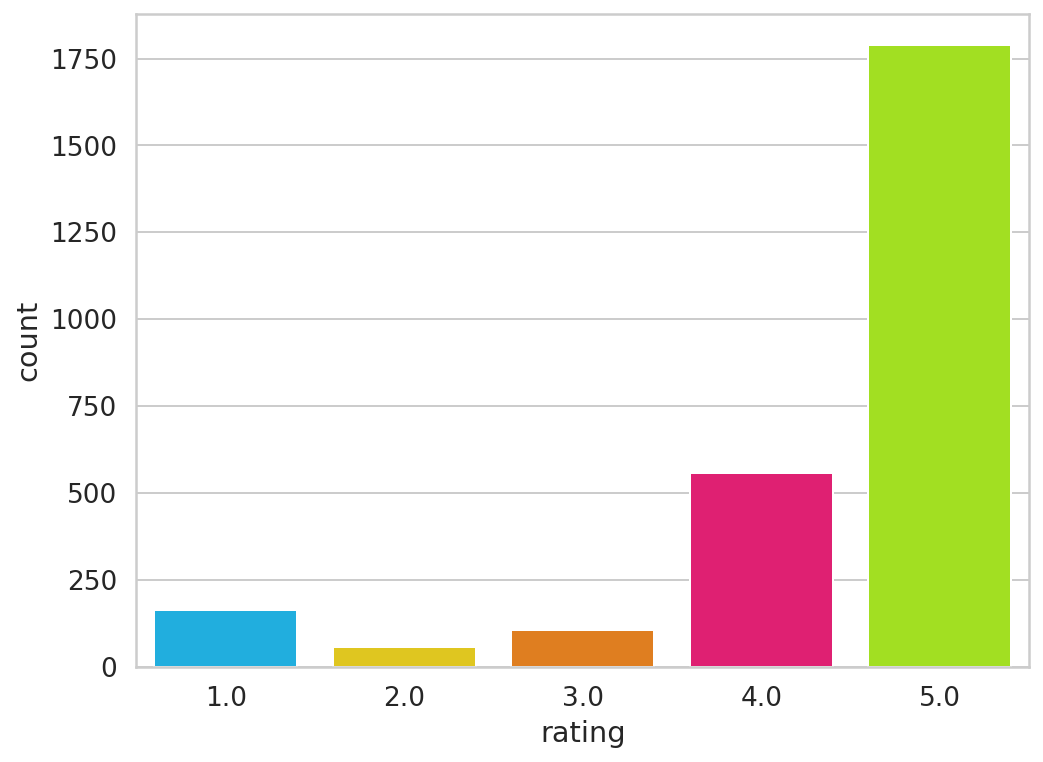

In [13]:
sns.countplot(df.rating)
plt.xlabel('rating');

There are very few samples for the rating range (1,3) and the rating 5 has most samples .  

* we need to define column sentiment according to the rating :
* we will use 3 sentiments [ negative, neutral, positive ] .

Now we need to divide the dataset in such range of "sentiment" that we get somewhat more and trainable samples per sentiment value.

* The range for negative is rating<=2
* The range for neutral is 2< rating <=4 
  * the range has been extended to 4 cause else we would have very few samples and training will yield no result for classifying neutral sentiment.
* The range for positive is rating > 4 . 

In [40]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif 2 < rating <= 4:
    return 1
  else :
    return 2

df['sentiment'] = df.rating.apply(to_sentiment) 

In [41]:
class_names = ['negative', 'neutral', 'positive']


lets plot to see the distribution for [sentiment]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

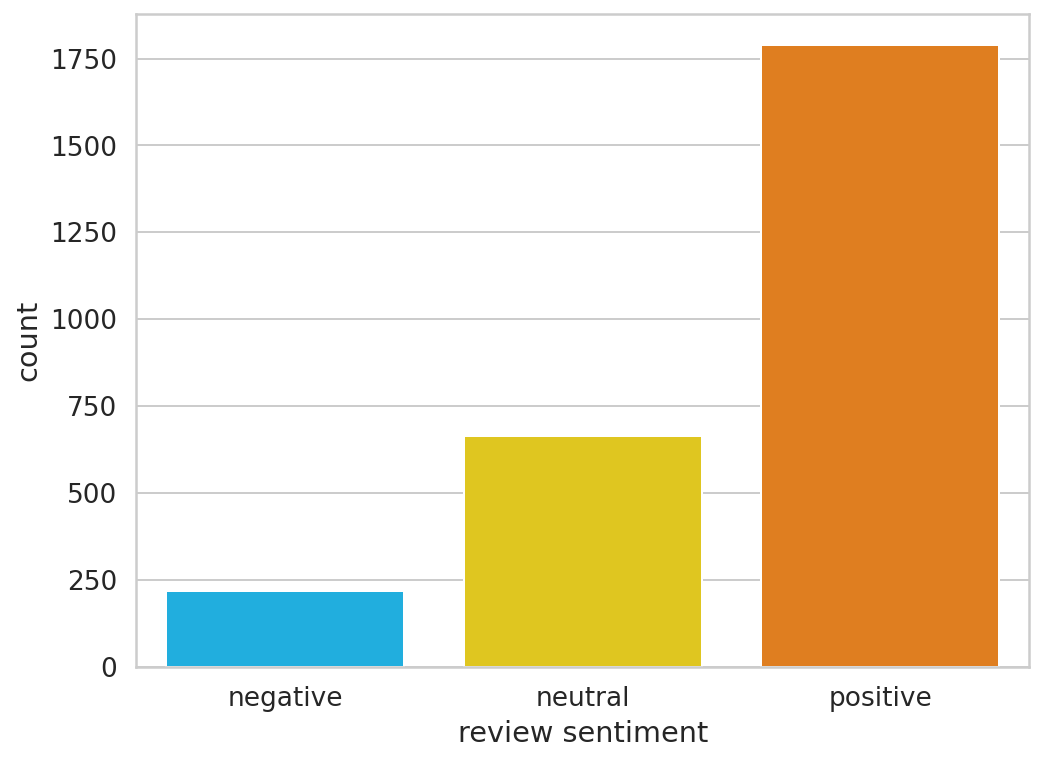

In [42]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

In [43]:
neg, neutral, pos = np.bincount(df.sentiment)

Lets find the count for each class.

In [44]:
counts=[neg,neutral, pos]
counts

[217, 664, 1788]

Lets find the count of total smaples.

In [45]:
n_classes=3
n_samples=sum(counts)
n_samples

2669

Lets determine the weights for each class of sentiment.

In [46]:
weights=[]
for count in counts:
    weights.append(n_samples / (n_classes * count))
    
weights=torch.tensor(weights)
weights

tensor([4.0998, 1.3399, 0.4976], dtype=torch.float64)

Let's load a pre-trained BertTokenizer:

In [47]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [48]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Trying out the tokenizer on a smaple text 

In [49]:
sample_txt = 'When was I last outside?\n I am stuck at home for 2 weeks.'

In [50]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside?
 I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


<h1> Special Tokens </h1>

1. [SEP] marker for ending of a sentence.

In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

2. [CLS] - we must add this token to the start of each sentence so BERT knows we're doing classification.

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

3. [PAD] - we use this token for padding

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

BERT understands tokens that were in the training set. Everything else can be encoded using the [UNK] (unknown) token:

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

All of that work can be done using the encode_plus() method:

In [63]:
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded to a length of 32:

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

attention mask has the same lenght

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

we can inverse the tokenization to have a look at the special tokens. 

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

<h2> Choosing Sequence Length

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [51]:
token_lens = []

for txt in df.body:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


and now plot the distribution 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


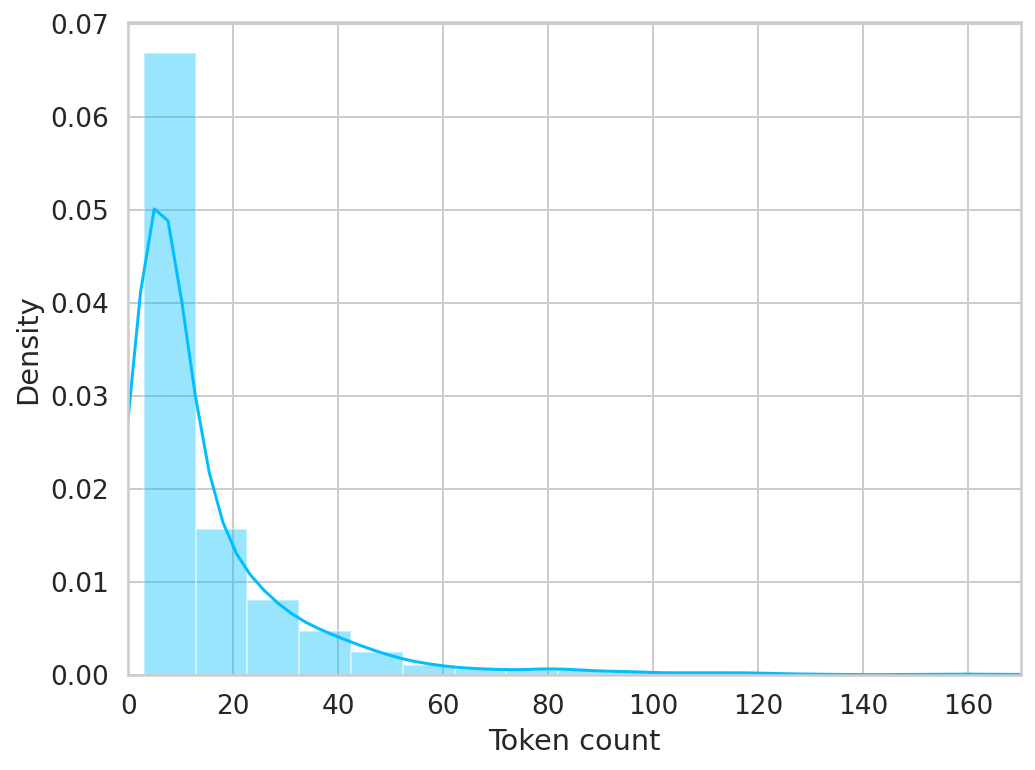

In [52]:
sns.distplot(token_lens)
plt.xlim([0, 170]);
plt.xlabel('Token count');

Most of the reveiws seem to contain less than 85 tokens but ww'll be on the safe side and chopse a maximum length of 100 .

In [53]:
MAX_LEN = 100

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [54]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
class AMReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews) #return no. of reviews we have 

  def __getitem__(self, item): #takes index of element from dataset
    review = str(self.reviews[item]) #string value of review at index item
    target = self.targets[item]

    encoding = tokenizer.encode_plus(
      review,
      max_length = self.max_len,
      add_special_tokens=True, # Add '[CLS]' and '[SEP]'
      return_token_type_ids=False,
      pad_to_max_length = True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }


Lets split the data :

In [55]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [56]:
df_train.shape, df_val.shape, df_test.shape

((1868, 5), (400, 5), (401, 5))

We also need to create a couple of data loaders. Here's a helper function to do it:

In [57]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = AMReviewDataset(
    reviews=df.body.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [58]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Let's have a look at an example batch from our training data loader:

In [59]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [60]:

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 100])
torch.Size([16, 100])
torch.Size([16])


<h2>Sentiment Classification with BERT and Hugging Face

load the model

In [61]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


And try to use it on the encoding of our sample text:

In [64]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask'],
  return_dict = False # this is needed to get a tensor as result
)

The last_hidden_state is a sequence of hidden states of the last layer of the model. Obtaining the pooled_output is done by applying the BertPooler on last_hidden_state:

In [65]:
last_hidden_state.shape

torch.Size([1, 32, 768])

We have the hidden state for each of our 32 tokens (the length of our example sequence). But why 768? This is the number of hidden units in the feedforward-networks. We can verify that by checking the config:

In [66]:
bert_model.config.hidden_size

768

You can think of the pooled_output as a summary of the content, according to BERT. Albeit, you might try and do better. Let's look at the shape of the output:

In [67]:
pooled_output.shape

torch.Size([1, 768])

<h2> Buliding a Sentiment Classifier

In [68]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict = False # this is needed to get a tensor as result
    )
    output = self.drop(pooled_output)
    return self.out(output)

Let's create an instance and move it to the GPU:

In [69]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [70]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 100])
torch.Size([16, 100])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [71]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2388, 0.4406, 0.3206],
        [0.2413, 0.3065, 0.4522],
        [0.3769, 0.2347, 0.3884],
        [0.2511, 0.3209, 0.4280],
        [0.5637, 0.2232, 0.2132],
        [0.2633, 0.3714, 0.3654],
        [0.2879, 0.2975, 0.4146],
        [0.3674, 0.2255, 0.4071],
        [0.3985, 0.1783, 0.4233],
        [0.3725, 0.1971, 0.4304],
        [0.3403, 0.1680, 0.4917],
        [0.3571, 0.1943, 0.4486],
        [0.2512, 0.3735, 0.3753],
        [0.3895, 0.2785, 0.3320],
        [0.4282, 0.2444, 0.3274],
        [0.1597, 0.3327, 0.5076]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

<h2> Training

To reproduce the training procedure from the BERT paper, we'll use the AdamW optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [72]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss(weight=weights.float()).to(device)

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

* Batch size: 16, 32
* Learning rate (Adam): 5e-5, 3e-5, 2e-5
* Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Let's continue with writing a helper function for training our model for one epoch:

In [73]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using clip_gradnorm.

Let's write another one that helps us evaluate the model on a given data loader:

In [74]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We'll also store the training history:

In [75]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.9265179415034432 accuracy 0.5546038543897217
Val   loss 0.7957792341709137 accuracy 0.28250000000000003

Epoch 2/10
----------
Train loss 0.6552989666278546 accuracy 0.6306209850107066
Val   loss 0.8271218061447143 accuracy 0.4625

Epoch 3/10
----------
Train loss 0.5218920035239978 accuracy 0.7039614561027837
Val   loss 0.8453405201435089 accuracy 0.605

Epoch 4/10
----------
Train loss 0.39674051978394514 accuracy 0.7799785867237687
Val   loss 0.9064993524551391 accuracy 0.6025

Epoch 5/10
----------
Train loss 0.30010277128372437 accuracy 0.8383297644539615
Val   loss 1.2138934928178786 accuracy 0.6125

Epoch 6/10
----------
Train loss 0.23825076535248604 accuracy 0.8725910064239829
Val   loss 1.5267853552103043 accuracy 0.605

Epoch 7/10
----------
Train loss 0.2143971915078214 accuracy 0.879014989293362
Val   loss 1.4617088556289672 accuracy 0.5825

Epoch 8/10
----------
Train loss 0.20367673986081958 accuracy 0.8849036402569593
Val   loss 1.3397722375392913 accuracy 

We can look at the training vs validation accuracy:

In [ ]:
"""
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
but it keeps giving TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.
so to hack around I did the below block and then plotted the values for train and val"""

In [76]:
tlist_train = torch.FloatTensor(history['train_acc'])
tlist_val = torch.FloatTensor(history['val_acc'])

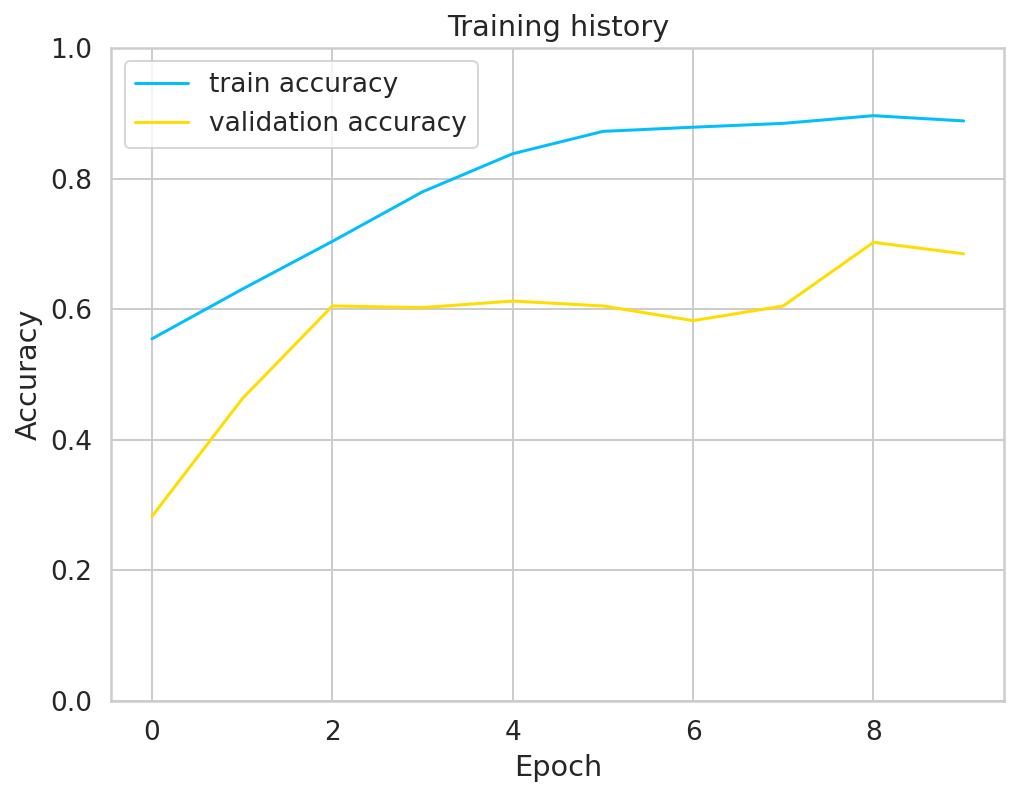

In [78]:
plt.plot(tlist_train, label='train accuracy')
plt.plot(tlist_val, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

Note that we're storing the state of the best model, indicated by the highest validation accuracy.

In [79]:
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<h2> Evaluation

 Let's start by calculating the accuracy on the test data:

In [80]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.6309226932668329

In [81]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [82]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Let's have a look at the classification report

In [83]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.72      0.61      0.66        38
     neutral       0.26      0.31      0.28        90
    positive       0.77      0.74      0.76       273

    accuracy                           0.63       401
   macro avg       0.58      0.55      0.57       401
weighted avg       0.65      0.63      0.64       401



Plotting the confussion Matrix

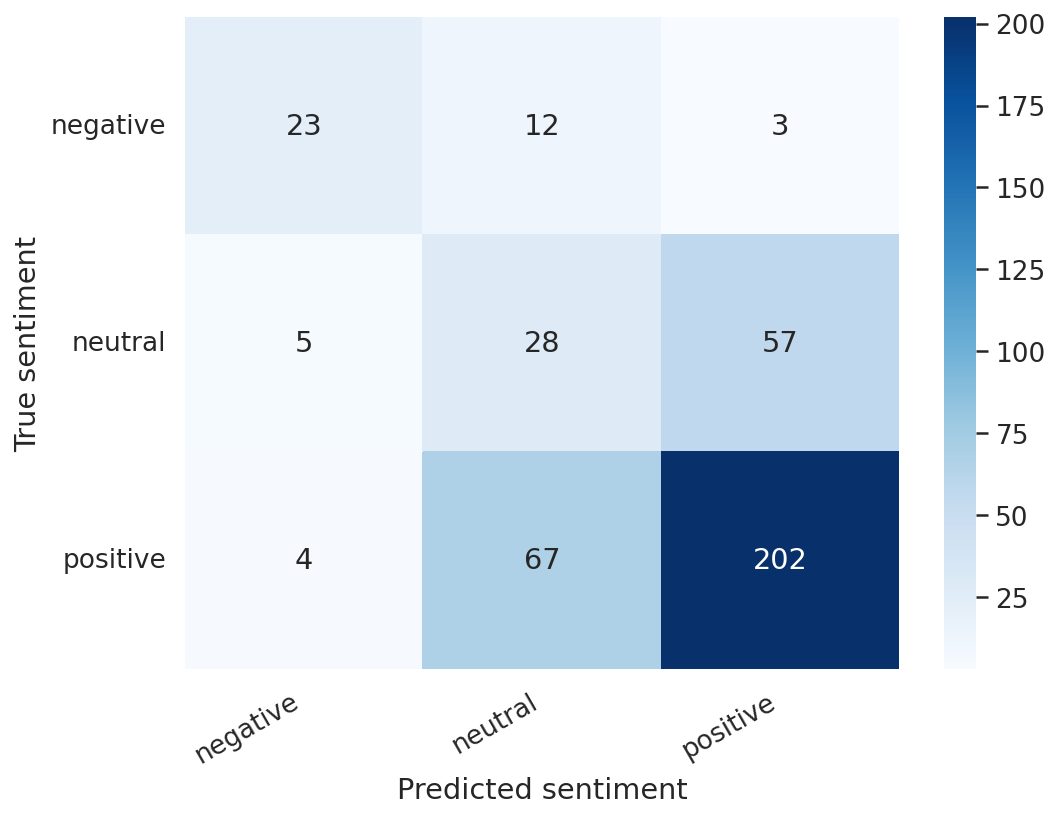

In [84]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

From the above plotted confussion matrix we can infer that our model can classify : 
* Positive - positive with high accuracy .
* neutral-positive and positive-neutral with moderate accuracy.
* It can classify the sentiments class alone (neg,neu,pos).

(the less conifdencefor few can be realted to the small amout of smaples in the dataset ; increasing them should give much better confussion matrix)

let's have a look at an example from our test data:

In [106]:
idx = np.random.randint(len(y_review_texts))

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')
pred_df

Good product

True sentiment: positive


,class_names,values
0,negative,0.001184
1,neutral,0.497514
2,positive,0.501302


Now we can look at the confidence of each sentiment of our model:

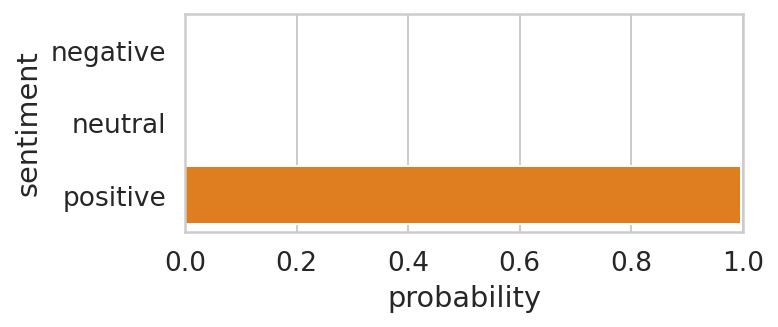

In [86]:
plt.figure(figsize=(5,2))
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

<h2>Predicting on Raw Text

Let's use our model to predict the sentiment of some raw text:

In [87]:
review_text = "its trash"

In [88]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Let's get the predictions from our model:

In [89]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
probs = F.softmax(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')



Review text: its trash
Sentiment  : negative


Review text: the mouse is nice works well but after 3 weeks it has started to malfunction and is irritating to plug and insert everytime!
Sentiment  : negative


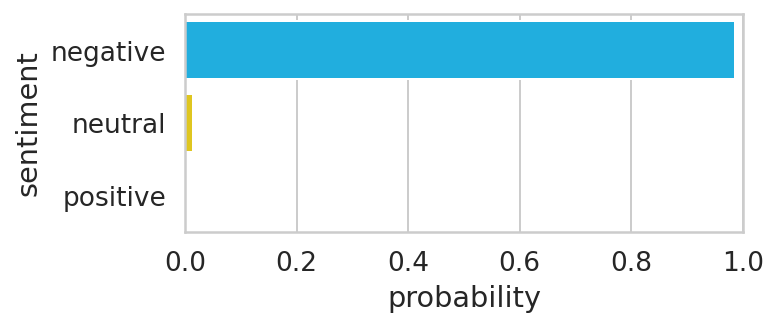

In [92]:
#@title MOUSE Review Sentiment Predictor
review = "the mouse is nice works well but after 3 weeks it has started to malfunction and is irritating to plug and insert everytime!" #@param {type:"string"}
encoded_review = tokenizer.encode_plus(
  review,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
# print(attention_mask.shape)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
probs = F.softmax(output, dim=1)
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': probs.flatten().cpu().detach().numpy()
})

plt.figure(figsize=(5,2))
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

print(f'Review text: {review}')
print(f'Sentiment  : {class_names[prediction]}')